<a href="https://colab.research.google.com/github/kmilonas/Dengue-fever/blob/main/Dengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dengue fever prediction
Introduction: this notebook tries to predict cases of dengue fever from environmental variables. It is done as part of a competition organized by [Driven Data](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).

Note: this is work in progress and the predictive accuracy has room for improvement. Further to using additional ML/AI techniques, building and applying domain knowledge would likely be useful given the relatively small sample size.


In [60]:
import pandas as pd
import numpy as np
%matplotlib inline
#from ggplot import *
from sklearn.ensemble import RandomForestRegressor
import unittest
import seaborn as sns
import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/dengue"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dengue_features_test.csv   dengue_labels_train.csv
dengue_features_train.csv  submission_format.csv


In [61]:
# Read data from GDrive; alternatively from the URLs bvelow
features = pd.read_csv('/content/drive/My Drive/dengue/dengue_features_train.csv') #https://drive.google.com/file/d/1EtfbBUhjaeVPQ93NhfpcMHKnwN486YX5/view?usp=sharing
labels = pd.read_csv('/content/drive/My Drive/dengue/dengue_labels_train.csv') #https://drive.google.com/file/d/12s9ZlRnxCGjXK9qZQN6utd37KkXMy4mf/view?usp=sharing
features_testset = pd.read_csv('/content/drive/My Drive/dengue/dengue_features_test.csv') #https://drive.google.com/file/d/1G4wILHaGlHjhHh2cePF90H_VLu2VBdyA/view?usp=sharing

In [62]:
labels.describe(include = "all")

,city,year,weekofyear,total_cases
count,1456,1456.000000,1456.000000,1456.000000
unique,2,NaN,NaN,NaN
top,sj,NaN,NaN,NaN
freq,936,NaN,NaN,NaN
mean,NaN,2001.031593,26.503434,24.675137
std,NaN,5.408314,15.019437,43.596000
min,NaN,1990.000000,1.000000,0.000000
25%,NaN,1997.000000,13.750000,5.000000
50%,NaN,2002.000000,26.500000,12.000000
75%,NaN,2005.000000,39.250000,28.000000


In [63]:
# Create nicer city names and date format
labels["date"] = pd.to_datetime(labels.year.astype(str), format='%Y') + pd.to_timedelta(
    labels.weekofyear.mul(7).astype(str) + ' days')

labels['city'] = labels['city'].str.replace('sj','San Juan').str.replace('iq','Iquitos')

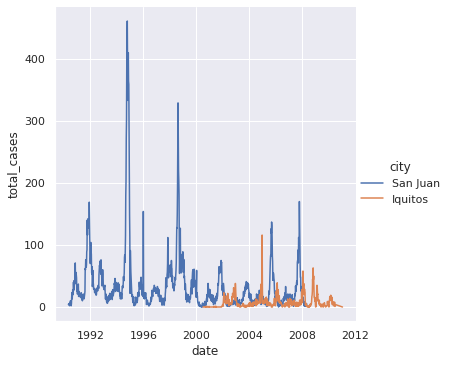

In [64]:
sns.set()
sns.relplot(x="date", y="total_cases", hue="city", kind="line",
            data=labels)

#### Observations

Little correlation across the two cities. Can therefore likely fit separate models by city.

The case count is extremely skewed.

No immediately apparent trends or seasonality.

In [19]:
# easier to have consistent measurement of temp in kelvin
features = pd.concat([features[col] - 273.15 if (col.find("_c") != -1) else features[col] 
                            for col in features], 1)                          
features.columns = features.columns.str.replace('_c','_k')
features.columns = features.columns.str.replace('reanalysis_avg_temp_k','reanalysis_avg_air_temp_k') #easier to have consistent naming

In [20]:
labels = labels.sort_values(['city','date'])

In [21]:
labels["city"].value_counts()

San Juan    936
Iquitos     520
Name: city, dtype: int64

##### Notes on missing data:
Some missing values in all variables except time and place vars

Use mean or max of related variables (e.g. measurement at other corners of city when the southeast is missing) 

In [22]:
features['eng_ndvi_mean'] = features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_ne']].mean(axis=1)
features['eng_ndvi_max'] = features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_ne']].max(axis=1)
features['eng_ndvi_min'] = features[['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_ne']].min(axis=1)

features['eng_precip'] = features[['precipitation_amt_mm','reanalysis_sat_precip_amt_mm', 'reanalysis_precip_amt_kg_per_m2']].mean(axis=1)
features['eng_diurn'] = features[['station_diur_temp_rng_k','reanalysis_tdtr_k']].mean(axis=1)

In [23]:
# repeat this over avg, min, and max. and add to the data
eng_temps = pd.concat([ features[[''.join(['station_',x,'_temp_k']), 
                                        ''.join(['reanalysis_', x, '_air_temp_k'])]].mean(axis=1) 
 for x in ['min','max', 'avg'] ], 1)

eng_temps.columns = [''.join(['eng_temp_',x]) for x in ['min','max', 'avg'] ]
eng_temps.columns.values

features = pd.concat([features, eng_temps], axis=1) 

In [25]:
# check that just one obs per date-city
obs_per_cty_date = np.unique(labels[['total_cases','city','date']].groupby(['city', 'date']).size().reset_index(name='counts')[['counts']].to_numpy())
assert obs_per_cty_date == np.array([1])

In [26]:
[features[[''.join(['station_',x,'_temp_k']), ''.join(
    ['reanalysis_', x, '_air_temp_k'])]].isna().sum() for x in ["min", "max", "avg"]]
# still some missing obs

[station_min_temp_k           14
 reanalysis_min_air_temp_k    10
 dtype: int64, station_max_temp_k           20
 reanalysis_max_air_temp_k    10
 dtype: int64, station_avg_temp_k           43
 reanalysis_avg_air_temp_k    10
 dtype: int64]

In [28]:
# create list of features to use in analysis - use only the engineered ones for now
features_cols_use = [i for i in features.columns if 'eng_' in i] 
features_cols_use.extend([i for i in features.columns if 'ndvi_' in i] )
features_cols_use.extend([i for i in features.columns if 'humidity' in i] )
features_cols_use = list(dict.fromkeys(features_cols_use)) #removing duplicates - TBA why arise
features_cols_use

['eng_ndvi_mean',
 'eng_ndvi_max',
 'eng_ndvi_min',
 'eng_precip',
 'eng_diurn',
 'eng_temp_min',
 'eng_temp_max',
 'eng_temp_avg',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'reanalysis_relative_humidity_percent',
 'reanalysis_specific_humidity_g_per_kg']

In [29]:
features_cols_use.extend(['city'])
X = features.loc[:,features_cols_use]

## Random forest
Start by a grid search over different hyperparameters to find model that best fits the data (in terms of cross-validation mean absolute error, i.e., the metric used for this competition)

In [32]:
y = labels['total_cases'].values
assert np.count_nonzero(np.isnan(train_y)) == 0 #check all y nonmissing

In [65]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.1) #choose a relatively small validation set since we already have a fairly small sample

In [35]:
categorical_features_colidx = features_cols_use.index('city')

# Impute missing values using iterative extreme RF
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [66]:
impute_estimator =   ExtraTreesRegressor(random_state=0,n_estimators = 30)# experimentation indicated that it doesn't get much better w higher

inner_estimator  = RandomForestRegressor(random_state = 42)

scaler = StandardScaler()

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [categorical_features_colidx])], remainder="passthrough")
    
estimator = make_pipeline(
    transformer,
    scaler,
   IterativeImputer(random_state=0, estimator=impute_estimator),
    inner_estimator, verbose = True
)
parameters = {}
nmaxdepth = [3,4,5]
nparsRF = [200, 300, 400]
parameters['randomforestregressor__n_estimators'] = nparsRF
parameters['randomforestregressor__max_depth'] = nmaxdepth

CV = GridSearchCV(estimator, parameters, scoring = 'neg_mean_absolute_error')
CV.fit(train_x, train_y)  

[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.9s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   0.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.6s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  21.0s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.7s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.0s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.6s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.7s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.0s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  21.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.1s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.1s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.3s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.9s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.6s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.5s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.1s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.6s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.0s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  21.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.3s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.7s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.2s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.8s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.9s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.9s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.5s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.4s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.5s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  20.1s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   2.4s
[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  24.4s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.5s


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='error',
                        

Visualize performance over grid of hyperparameters (maximum depth and number of trees)

Text(0.5, 0, 'mean_test_score')

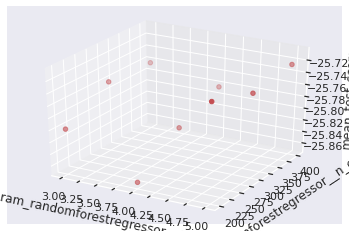

In [67]:
cvresults = pd.DataFrame(CV.cv_results_)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cvresults['param_randomforestregressor__max_depth'], cvresults['param_randomforestregressor__n_estimators'], cvresults['mean_test_score'], c='r', marker='o')
ax.set_xlabel('param_randomforestregressor__max_depth')
ax.set_ylabel('param_randomforestregressor__n_estimators')
ax.set_zlabel('mean_test_score')

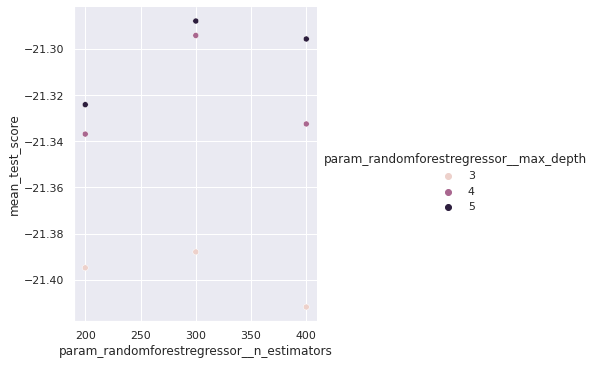

In [39]:
sns.relplot(x='param_randomforestregressor__n_estimators', y = 'mean_test_score', hue='param_randomforestregressor__max_depth', kind='scatter', data=cvresults)

In [73]:
estimator = CV.best_estimator_ # choose the best parameterization and use it for prediction after fitting to specified training data
estimator.fit(train_x,train_y)

[Pipeline] . (step 1 of 4) Processing columntransformer, total=   0.0s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[Pipeline] .. (step 3 of 4) Processing iterativeimputer, total=  19.8s
[Pipeline]  (step 4 of 4) Processing randomforestregressor, total=   1.2s


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  [14])],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_me...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
    

In [72]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y,estimator.predict(val_x))

22.07566005739815

Visualize performance on the validation and training sets. Will see that currently we fit the training set reasonably well but do poorly on the test set, indicating an overfit to the training data

Text(0.5, 0.98, 'Test set')

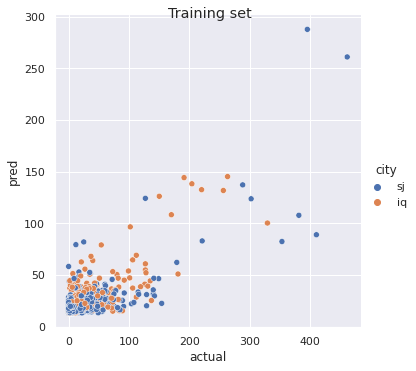

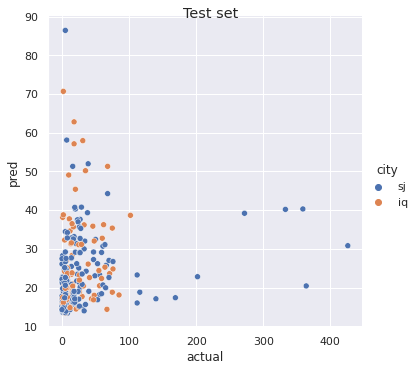

In [44]:
dataforplot_train = pd.DataFrame({'actual': train_y, 'pred': estimator.predict(train_x), 'city': train_x['city']})
ptrain = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_train)
ptrain.fig.suptitle("Training set")

dataforplot_test = pd.DataFrame({'actual': test_y, 'pred': estimator.predict(test_x), 'city': test_x['city']})
ptest = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_test)
ptest.fig.suptitle("Test set")

# XGBoost

In [57]:
from xgboost import XGBRegressor

def huber_approx_obj(preds, dtrain): #approximate MAE, since that loss won't work since not everywhere differentiable
    d = preds - dtrain #.get_labels() #remove .get_labels() for sklearn
    h = 1  #h is delta in the graphic at https://stackoverflow.com/questions/45006341/xgboost-how-to-use-mae-as-objective-function
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

inner_estimator  = XGBRegressor(objective=huber_approx_obj)

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [categorical_features_colidx])], remainder="passthrough")
    
estimatorXGB = make_pipeline(
    transformer,
    inner_estimator, verbose = True
)
parameters = {}
nmaxdepth = [3,4,5]
nparsRF = [200, 300, 400]
parameters['xgbregressor__max_depth'] = nmaxdepth
CV_XGB = GridSearchCV(estimatorXGB, parameters, scoring = 'neg_mean_absolute_error')
CV_XGB.fit(X, y)  

estimatorXGB.get_params().keys()


[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[19:01:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   0.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[19:01:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   0.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[19:01:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[Pipeline] ...... (step 2 of 2) Processing xgbregressor, total=   0.1s
[Pipeline] . (step 1 of 2) Processing columntransformer, total=   0.0s
[19:01:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squareder

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'xgbregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__cat', 'columntransformer__cat__categories', 'columntransformer__cat__drop', 'columntransformer__cat__dtype', 'columntransformer__cat__handle_unknown', 'columntransformer__cat__sparse', 'xgbregressor__base_score', 'xgbregressor__booster', 'xgbregressor__colsample_bylevel', 'xgbregressor__colsample_bynode', 'xgbregressor__colsample_bytree', 'xgbregressor__gamma', 'xgbregressor__importance_type', 'xgbregressor__learning_rate', 'xgbregressor__max_delta_step', 'xgbregressor__max_depth', 'xgbregressor__min_child_weight', 'xgbregressor__missing', 'xgbregressor__n_estimators', 'xgbregressor__n_jobs', 'xgbregressor__nthread', 'xgbregressor__objective', 'xgbregressor__random_state', 'xgbregressor

Analyze performance. Further improvement is needed since it's currently poor on both training and validation sets.

In [58]:
  # analyse performance
estimatorXGB = CV_XGB.best_estimator_ # choose the best parameterization and use it for prediction
estimatorXGB.fit(train_x,train_y)
mean_absolute_error(val_y,estimatorXGB.predict(val_x))

10859.467716582834

Text(0.5, 0.98, 'Test set; XGBoost')

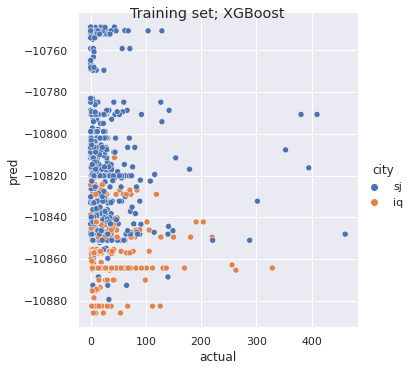

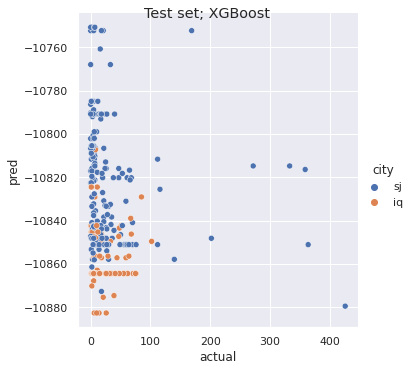

In [59]:
dataforplot_train = pd.DataFrame({'actual': train_y, 'pred': estimatorXGB.predict(train_x), 'city': train_x['city']})
ptrain = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_train)
ptrain.fig.suptitle("Training set; XGBoost")

dataforplot_test = pd.DataFrame({'actual': val_y, 'pred': estimatorXGB.predict(val_x), 'city': val_x['city']})
ptest = sns.relplot(x='actual', y = 'pred', hue='city', kind='scatter', data=dataforplot_test)
ptest.fig.suptitle("Test set; XGBoost")